In [1]:
import festim as F
import numpy as np
from festim2_solve_functions import *
from festim2_barrier_sweep_functions import *
from pathlib import Path
import csv

In [2]:
T = 600  # K
P_up = 100 # Pa
barrier_thickness = 3e-3  # m
substrate_thickness = 3e-3  # m

results_folder = "results"
results_dir = Path(results_folder)  # convert str to Path
results_dir.mkdir(parents=True, exist_ok=True)
csv_path = results_dir / "sweep_results.csv"

In [ ]:
base_params = {
    "D_0_barrier": 1e-8,  # m2/s
    "E_D_barrier": 0.39,  # eV
    "S_0_barrier": 1e22,  # mol/m3Pa^0.5
    "E_S_barrier": 1.04,  # eV
    "K_r_0_barrier": 3.2e-15,  # m2/s Anderl 1992
    "E_K_r_barrier": 1.16,  # eV Anderl 1992
    "D_0_substrate": 4.1e-7,  # m2/s
    "E_D_substrate": 0.39,  # eV
    "S_0_substrate": 1.87e24,  # mol/m3Pa^0.5
    "E_S_substrate": 1.04,  # eV
    "K_r_0_substrate": 5.4e-19,  # m2/s
    "E_K_r_substrate": 15600 / 96491,  # converting to eV from F. WAELBROECK et al
}

n_points_S = 10
n_points_D = 2
S_0_limits = (1e19, 1e23)  # mol/m3Pa^0.5
D_0_limits = (1e-10, 1e-4)  # m2/s

# generate list of parameter sets to run
param_list = generate_params_list(base_params, S_0_limits, D_0_limits, n_points_S, n_points_D)

In [4]:
need_header = not csv_path.exists()

with csv_path.open("w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for run_num in range(len(param_list)):
        params = param_list[run_num]

        my_model = F.HydrogenTransportProblemDiscontinuous()

        create_mesh(my_model, barrier_thickness, substrate_thickness)

        barrier, substrate, H = assign_materials_and_domains(my_model, params, barrier_thickness, substrate_thickness, T=T, P_up=P_up)

        my_model.settings = F.Settings(
            atol=1e-6,
            rtol=1e-10,
            transient=False,
        )

        barrier_export, substrate_export = set_exports(my_model, barrier, substrate, H)

        my_model.initialise()
        my_model.run()

        C1 = barrier_export.data[0][0]  # concentration at the left side of the barrier
        Cm1 = barrier_export.data[0][-1]  # concentration at the right side of the barrier
        Cm2 = substrate_export.data[0][0]  # concentration at the left side of the substrate
        C2 = substrate_export.data[0][-1]  # concentration at the right side of the substrate
        W, R = compute_W_R(params, barrier_thickness, substrate_thickness, T=T, P_up=P_up)

        row = {
            "run": run_num,
            "barrier_thickness": float(barrier_thickness),
            "substrate_thickness": float(substrate_thickness),
            "T": float(T),
            "P_up": float(P_up),
            "C1": C1,
            "Cm1": Cm1,
            "Cm2": Cm2,
            "C2": C2,
            "W": float(W),
            "R": float(R),
        }
        for k in param_keys:
            row[k] = float(params[k])

        with csv_path.open("a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writerow(row)

        if run_num % 100 == 0:
            print(f"Completed run {run_num} of {len(param_list)}")
    


Completed run 0 of 400
Completed run 100 of 400
Completed run 200 of 400
Completed run 300 of 400


Saved plot to: figures/w_vs_r.png


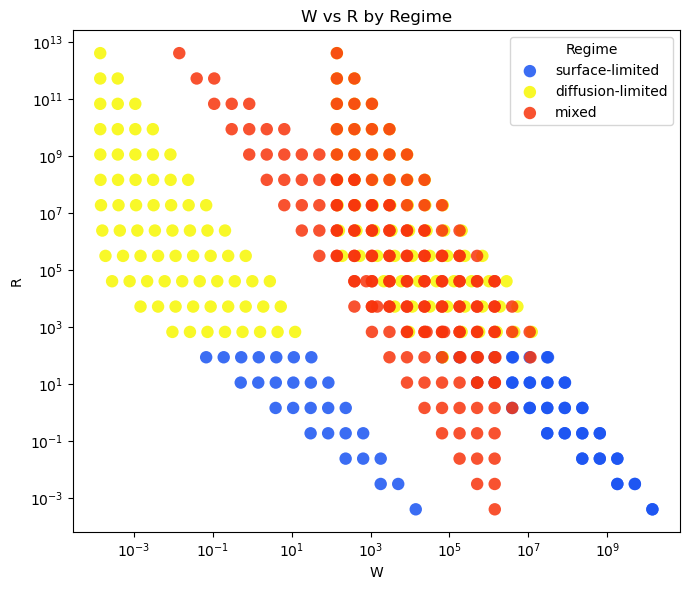

In [5]:
import matplotlib.pyplot as plt
from typing import Tuple, Iterable, Optional
import math

tol = 0.05  # 5%

annotated = analyze_csv_and_plot(csv_path, tolerance=tol, save_path="figures/w_vs_r.png")